In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')


# --- Evaluate with RMSLE ---
def rmsle(y_true, y_pred):
    # Clip predictions to avoid log(0) errors
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))


df_train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
df_train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [13]:
df_train.columns = df_train.columns.str.replace(" ", "_").str.replace(".", "_")

# Encode categorical 'Sex' with OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
sex_encoded = encoder.fit_transform(df_train[['Sex']])
sex_encoded_df = pd.DataFrame(sex_encoded, columns=encoder.get_feature_names_out(['Sex']))

# Combine features
df_model = pd.concat([df_train.drop(columns=['id', 'Sex']), sex_encoded_df], axis=1)
X_all = df_model.drop(columns='Rings')
y = df_model['Rings']

# --- Define two models ---
X2 = X_all                                  # Model 2: includes Sex
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=55)
model2 = LinearRegression().fit(X2_train, y_train)
rmsle2 = rmsle(y_test, model2.predict(X2_test))
print(f"Model 2 RMSLE (with Sex): {rmsle2:.4f}")

Model 2 RMSLE (with Sex): 0.1640


In [14]:
# --- Assumption Checks for Model ---
# Add constant for statsmodels
X2_train_const = sm.add_constant(X2_train)
ols_model2 = sm.OLS(y_train, X2_train_const).fit()
print(ols_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                 1.243e+04
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        14:34:48   Log-Likelihood:            -1.5265e+05
No. Observations:               72492   AIC:                         3.053e+05
Df Residuals:                   72482   BIC:                         3.054e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.8355      0.068     56.

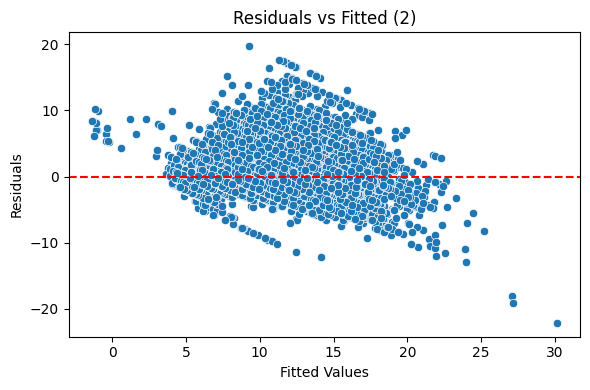

In [15]:
# Residuals
residuals2 = y_train - ols_model2.predict(X2_train_const)

# Linearity & Homoscedasticity
plt.figure(figsize=(6, 4))
sns.scatterplot(x=ols_model2.predict(X2_train_const), y=residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (2)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

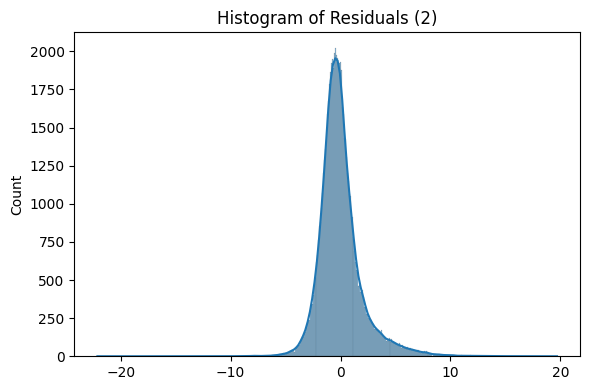

In [16]:
# Normality of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals2, kde=True)
plt.title("Histogram of Residuals (2)")
plt.tight_layout()
plt.show()

In [17]:
# Multicollinearity (VIF)
vif_data2 = pd.DataFrame()
vif_data2["Feature"] = X2_train.columns
vif_data2["VIF"] = [variance_inflation_factor(X2_train.values, i) for i in range(X2_train.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data2)


Variance Inflation Factors:
          Feature         VIF
0          Length  935.799209
1        Diameter  965.606478
2          Height  106.627443
3    Whole_weight  269.878236
4  Whole_weight_1   79.609525
5  Whole_weight_2   76.721184
6    Shell_weight   71.806821
7           Sex_I    2.937064
8           Sex_M    2.120295


In [18]:
# --- Load test data ---
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
test_ids = test_df["id"]

# Clean column names
test_df.columns = test_df.columns.str.replace(" ", "_").str.replace(".", "_")

# One-hot encode 'Sex' column (must match training encoding)
sex_encoded_test = encoder.transform(test_df[['Sex']])
sex_encoded_test_df = pd.DataFrame(sex_encoded_test, columns=encoder.get_feature_names_out(['Sex']))

# Combine encoded columns
test_model_df = pd.concat([test_df.drop(columns=['id', 'Sex']), sex_encoded_test_df], axis=1)

# --- Predict using Model 2 (with Sex) ---
X_test_model2 = test_model_df
preds_model2 = model2.predict(X_test_model2)
preds_model2 = np.maximum(0, preds_model2)

# --- Save submission files ---
submission2 = pd.DataFrame({'id': test_ids, 'Rings': preds_model2})
submission2.to_csv("/kaggle/working/submission_model2.csv", index=False)
print("Submissions saved: submission_model2.csv")

Submissions saved: submission_model2.csv
